importing necessary libraries

In [ ]:
# Importing the required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GRU
from tensorflow.keras.layers import TimeDistributed, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

specifies the directory where the data files are located and where program is currently running

In [ ]:
BASE_DIR = '/content/g.drive/MyDrive/Flickr8k/flickr8k'
WORKING_DIR = ''

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 38.2 MB/s eta 0:00:00


loads the vgg16 model pre-trained on the ImageNet dataset, restructures it, and prints a summary of the model architecture.

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet')
# Remove the last layer of the model
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)



553467096/553467096 [==============================] - 3s 0us/step


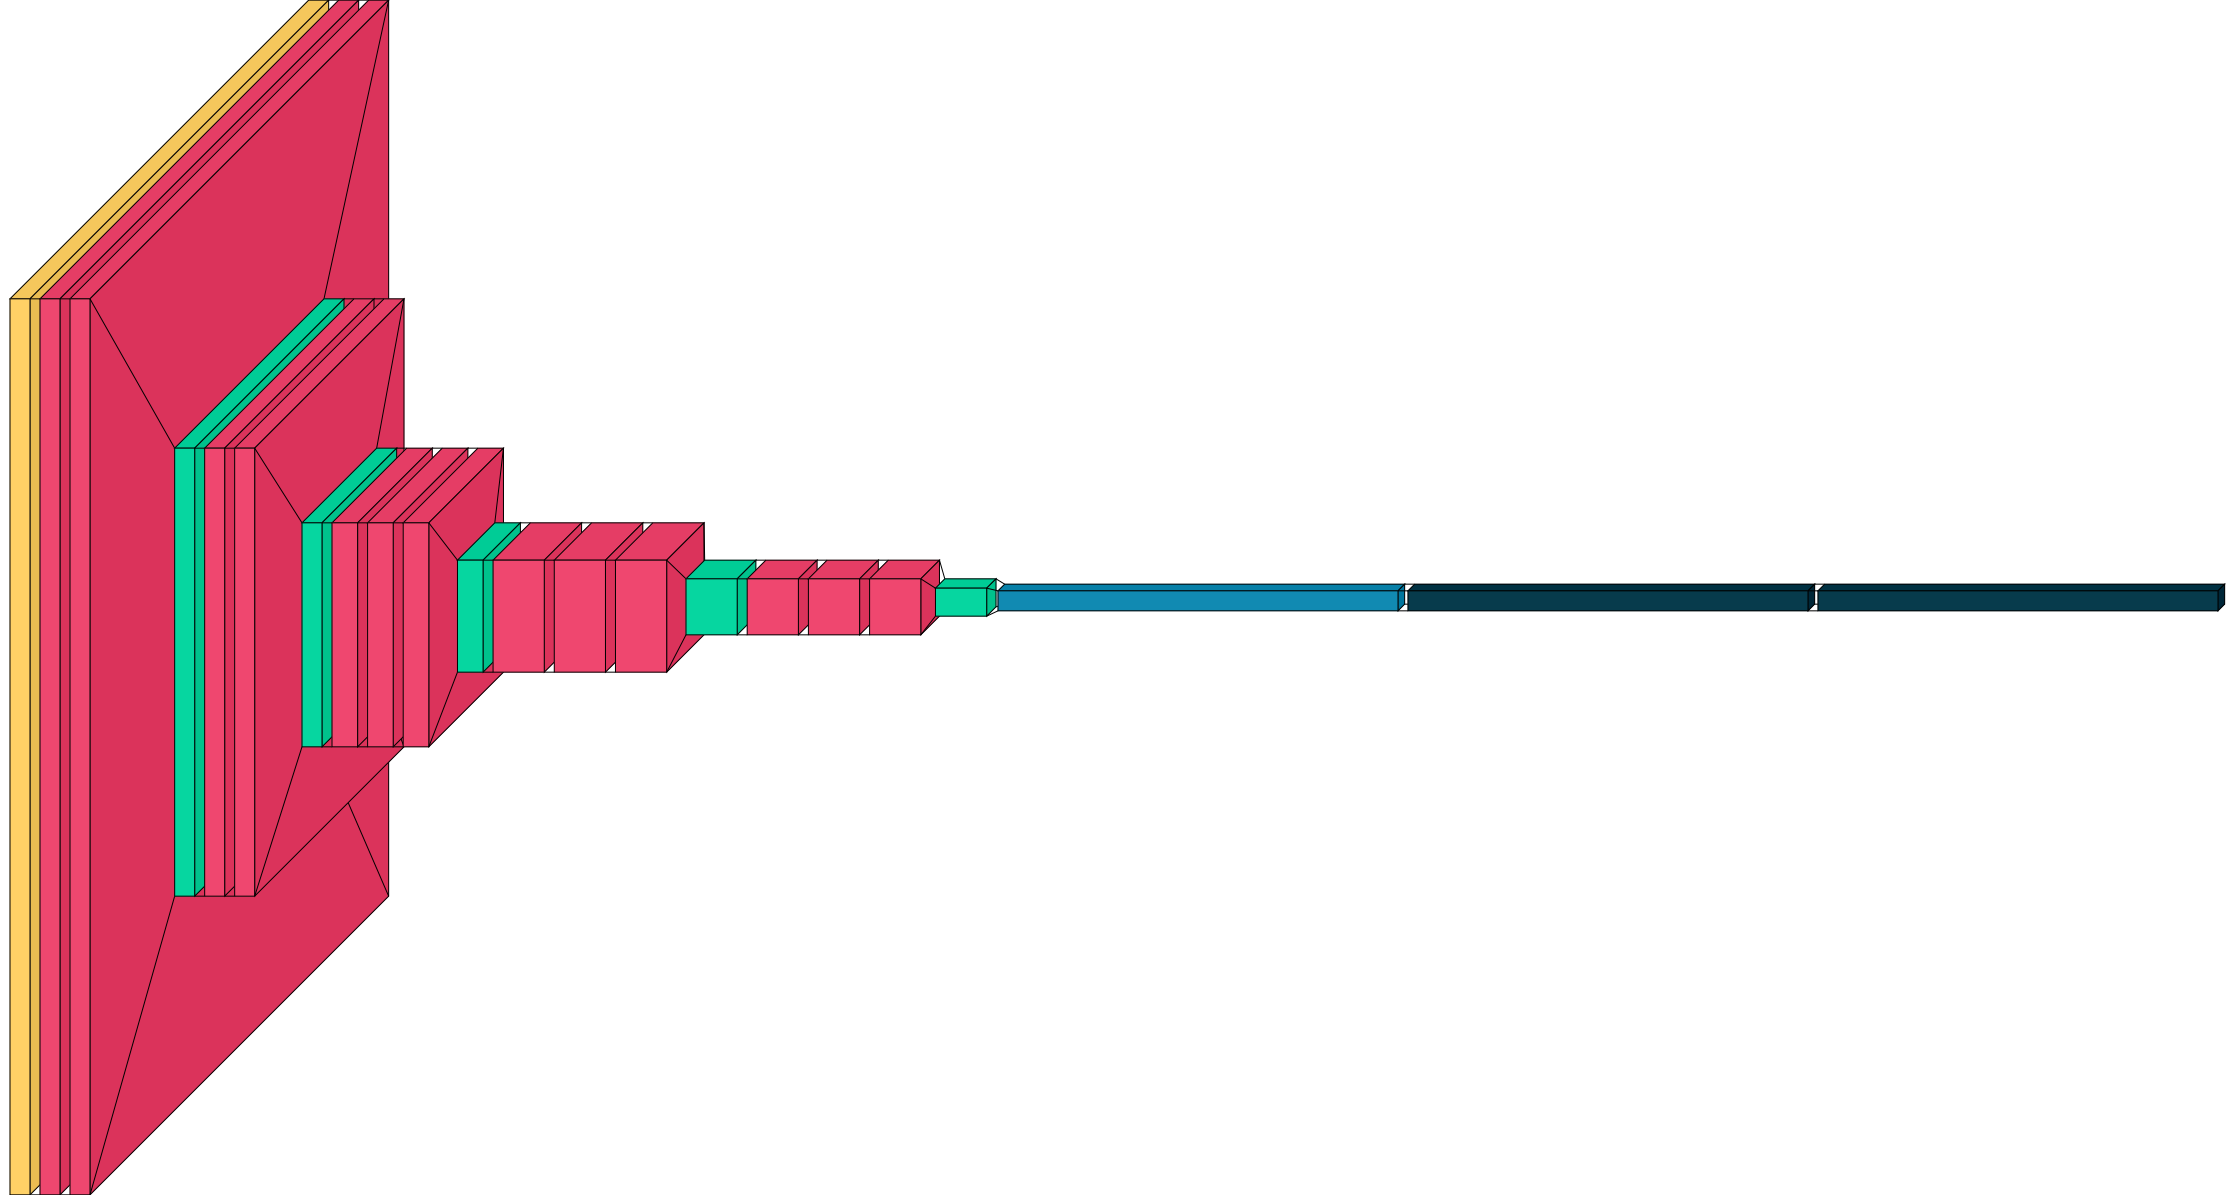

In [ ]:
import visualkeras
visualkeras.layered_view(model)

creates a dictionary called features, and a string called directory that stores the path to a directory on the file system.

In [ ]:
import os
features = {}
directory = os.path.join(BASE_DIR, '/content/g.drive/MyDrive/Flickr8k/flickr8k/images')

In [ ]:
from google.colab import drive
drive.mount('/content/g.drive')

Mounted at /content/g.drive


In [ ]:
!pip show keras
import keras
print(keras.__version__)

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: keras-vis, tensorflow
2.12.0


uses the pre-trained VGG16 model to extract features from images in a directory and stores the features in a dictionary called features

In [ ]:
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf

for img_name in tqdm(os.listdir(directory)):
    if img_name == '.ipynb_checkpoints':
        continue
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Vgg16
    image=tf.keras.applications.imagenet_utils.preprocess_input(image, data_format=None, mode='tf')
    #image = preprocess_input(image, mode='tf')
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8143 [00:00<?, ?it/s]

This code defines a function extract_features that takes in an image filename and a pre-trained VGG16 model and returns the features extracted from the image by the model.

In [ ]:
!pip install keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# load and prepare the image
def extract_features(filename, model):
    # load the image
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for VGG16
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    return feature


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This code saves the features extracted from the images in a Python pickle file using the pickle.dump function.
The extracted features are stored in the features dictionary, which has the image IDs as keys and the extracted features as values.

In [ ]:
# store features in pickle
import pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

This code loads the features extracted from the images that were previously stored in a Python pickle file using the pickle.load function.

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

 opens and reads the contents of a text file called captions.txt. The with statement is used with the open function to open the file in read mode ('r').

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

creates a dictionary called mapping that maps image IDs to their corresponding captions.

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
  # split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
  image_id = image_id.split('.')[0]
    # convert caption list to string
  caption = " ".join(caption)
    # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
    # store the caption
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

The clean() function takes the mapping dictionary as input, which maps each image to its corresponding captions. It then iterates over the captions for each image and applies a series of preprocessing steps to clean and format the captions.

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
       #take one caption at a time
       caption = captions[i]
#preprocessing steps
#convert to lowercase
       caption = caption.lower()
#delete digits, special chars, etc.,
       caption = caption.replace('[^A-Za-z]', '')
# delete additional spaces
       caption = caption.replace('\s+', ' ')
# add start and end tags to the caption
       caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
       captions[i] = caption

showing the contents of the mapping dictionary before pre-processing of text

In [ ]:
# before preprocess of text
mapping['1015118661_980735411b']

['A boy smiles in front of a stony wall in a city .',
 'A little boy is standing on the street while a man in overalls is working on a stone wall .',
 'A young boy runs aross the street .',
 'A young child is walking on a stone paved street with a metal pole and a man behind him .',
 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']

The clean() function performs the pre-processing of the captions in the mapping dictionary.

In [ ]:
# preprocess the text
clean(mapping)

We can check the preprocessed captions for an image by accessing its key in the mapping dictionary,This will return a list of preprocessed captions for the image with ID

In [ ]:
# after preprocess of text
mapping['1015118661_980735411b']

['startseq boy smiles in front of stony wall in city endseq',
 'startseq little boy is standing on the street while man in overalls is working on stone wall endseq',
 'startseq young boy runs aross the street endseq',
 'startseq young child is walking on stone paved street with metal pole and man behind him endseq',
 'startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq']

The resulting all_captions list will contain all preprocessed captions for all images in the dataset.

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

the first 10 captions in the all_captions list

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

The max_length variable stores the maximum length of the captions in all_captions list.

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

code is splitting the image_ids list into train and test sets. The train set will contain 90% of the images, and the test set will contain the remaining 10%

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


implementation of the CNN-GRU architecture for image caption generation.

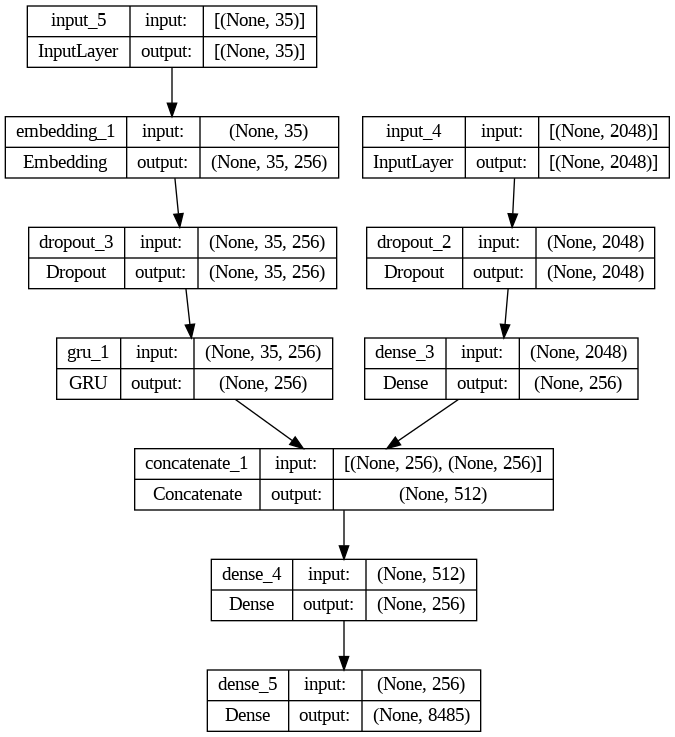

In [ ]:
from tensorflow.keras.utils import plot_model

# Define the caption generator model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = GRU(256)(se2)

decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


trains the previously defined image captioning model using the data generator.

In [ ]:
def train_model(model, mapping, features, tokenizer, epochs=50, batch_size=32):
    # Create train and test image lists
    image_ids = list(mapping.keys())
    split = int(len(image_ids) * 0.90)
    train = image_ids[:split]
    test = image_ids[split:]

    # Loop over epochs
    for i in range(epochs):
        # Create data generator for training set
        train_generator = data_generator(data_keys=train, mapping=mapping, features=features, tokenizer=tokenizer, max_length=1000, vocab_size=100, batch_size=batch_size)

        # Create data generator for test set
        test_generator = data_generator(data_keys=test, mapping=mapping, features=features, tokenizer=tokenizer, max_length=1000, vocab_size=100, batch_size=batch_size)

        # Fit the model for one epoch
        model.fit(train_generator, steps_per_epoch=len(train)//batch_size, epochs=1, verbose=1, validation_data=test_generator, validation_steps=len(test)//batch_size)

    return model

 saves the trained image captioning model to a file named 'best_model.h5' in the working directory

In [ ]:
# save the model
model.save(WORKING_DIR+'best_model.h5')

function takes an integer and a tokenizer as input and returns the corresponding word in the tokenizer's vocabulary.


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

This function takes a trained image captioning model, an image, a tokenizer, and the maximum length of a sequence as input. It generates a caption for the given image using the trained model.

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

or evaluating the performance of the image caption generation model on the test set using the BLEU score metric.

In [ ]:
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # check if key exists in features dictionary
    if key in features:
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 810/810 [41:45<00:00,  3.09s/it]
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram ord

BLEU-1: 0.028052
BLEU-2: 0.000000


This function generates and prints the actual and predicted captions for an input image

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_name = "97577988_65e2eae14a.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

generates caption for the given image

---------------------Actual---------------------
startseq man mountain climbing up an icy mountain endseq
startseq an climber is ascending an ice covered rock face endseq
startseq person in orange climbs sheer cliff face covered in snow and ice endseq
startseq person in yellow jacket is climbing up snow covered rocks endseq
startseq there is climber scaling snowy mountainside endseq
--------------------Predicted--------------------
startseq indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor indoor


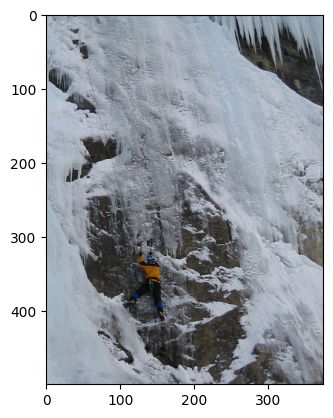

In [ ]:
generate_caption("1015118661_980735411b.jpg")